<a href="https://colab.research.google.com/github/StayFrostea/LearningML/blob/main/Roszell_Thesis_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the first baseline model of the MRI Thesis

### Importing the dataset from Googler Drive

In [13]:
## Loading the google drive where I stored the MOSMEDDATA files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
toTrain_path = '/content/drive/MyDrive/Colab Notebooks/Data/Keras MRI'
toPredict_path = '/content/drive/MyDrive/Colab Notebooks/Data/Keras MRI'

toTrain_path_output = '/content/drive/MyDrive/Colab Notebooks/Data/Keras MRI/output'
toPredict_path_output = '/content/drive/MyDrive/Colab Notebooks/Data/Keras MRI/output'

### Sectioning off some of the data for prediction

In [17]:
# ## A tool for spliting the image files before processing
# !pip install split-folders
# import splitfolders

# ## 80/20 Split of the data
# splitfolders.ratio(toTrain_path, output=toTrain_path_output, seed=1337, ratio=(0.8, 0.2))
# splitfolders.ratio(toPredict_path, output=toPredict_path_output, seed=1337, ratio=(0.8, 0.2))

In [18]:
import os

## Alzheimers Files
path, dirs, files = next(os.walk(toTrain_path_output + '/train/AD'))
file_count = len(files)
file_count

53

In [19]:
## Normal Control Files
path, dirs, files = next(os.walk(toTrain_path_output + '/train/NC'))
file_count = len(files)
file_count

47

In [20]:
import numpy as np
import nibabel as nib
from nibabel.testing import data_path
from scipy import ndimage

In [21]:
## Read Function
def read_NifTi(fp):
    scan = nib.load(fp)
    scan = scan.get_fdata()
    return scan

## Resize function
def resizeVolume(img):

    ## desired
    d_depth = 64
    d_width = 224
    d_height = 224

    ## current
    c_depth = img.shape[-1]
    c_width = img.shape[0]
    c_height = img.shape[1]

    ## factor to change by
    d_factor = d_depth/c_depth
    w_factor = d_width/c_width
    h_factor = d_height/c_height

    ## Adjust proper rotation
    img = ndimage.rotate(img, 90, reshape = False)

    ## apply the factors
    img = ndimage.zoom(img, (w_factor, h_factor, d_factor), order = 1)

    return img
  
## Normalize Function
def normalizeVolume(vol):
    min = -1000
    max = 400
    vol[vol < min] = min
    vol[vol > max] = max
    vol = (vol - min) / (max - min)
    vol = vol.astype("float32")
    return vol

## Processing Function
def processVolume(path):
    volume = read_NifTi(path)
    volume = normalizeVolume(volume)
    volume = resizeVolume(volume)
    return volume

In [22]:
## Setting up the filepaths for each file in NC
normal_scan_paths = [
    os.path.join(os.getcwd(), toTrain_path_output + '/train/NC', x)
    for x in os.listdir(toTrain_path_output + '/train/NC')
]

## Setting up the filepaths for each file in class 2
alzheimer_scan_paths = [
    os.path.join(os.getcwd(), toTrain_path_output + '/train/AD', x)
    for x in os.listdir(toTrain_path_output + '/train/AD')
]

In [9]:
## Normal Subject files into numpy arrays
normal_volumes = np.array([processVolume(path) for path in normal_scan_paths])
normal_volume_labels = np.array([0 for _ in range(len(normal_volumes))])

In [10]:
## Alzheimer's Subject files into numpy arrays
alzheimer_volumes = np.array([processVolume(path) for path in alzheimer_scan_paths])
alzheimer_volume_labels = np.array([1 for _ in range(len(alzheimer_volumes))])

In [11]:
print("MRI scans with normal neuro presentation: " + str(len(normal_scan_paths)))
print("MRI scans with abnormal alzheimner's presentation: " + str(len(alzheimer_scan_paths)))

MRI scans with normal neuro presentation: 47
MRI scans with abnormal alzheimner's presentation: 53


In [12]:
## Is there an error here?

## 60/20 Split of volumes
X_train = np.concatenate((alzheimer_volumes[:40], normal_volumes[:40]), axis=0)
y_train = np.concatenate((alzheimer_volume_labels[:40], normal_volume_labels[:40]), axis=0)

X_val = np.concatenate((alzheimer_volumes[40:], normal_volumes[40:]), axis=0)
y_val = np.concatenate((alzheimer_volume_labels[40:], normal_volume_labels[40:]), axis=0)

print(   
"Number of samples in train and validation are %d and %d."
    % (X_train.shape[0], X_val.shape[0])
)
X_train.shape

Number of samples in train and validation are 80 and 20.


(80, 224, 224, 64)

### Preprocessing Directives

In [23]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [24]:
## Rotation Augmentation
def rotate(volume):

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

In [25]:
## For now we will not do preprocessing
## Only add the the stack to match dimensionality

def train_preprocess(volume, label):
  # volume = rotate(volume)
  volume = tf.stack((volume,)*3, axis = 3)
  return volume, label
def valid_preprocess(volume, label):
  volume = tf.stack((volume,)*3, axis = 3)
  return volume, label

In [26]:
## Run the preprocessing Steps
X_train_r, y_train_r = train_preprocess(X_train, y_train)
X_val_r, y_val_r = valid_preprocess(X_val, y_train)

NameError: ignored

In [27]:
## Slicing Function
def threeDToTwoD(threeDVol, numVol):

  twoDVol = np.zeros((numVol*64, 224, 224, 3), np.float32)

  count = 0

  for i in range(numVol):
    for j in range(64):
      twoDVol[count] = threeDVol[i,:,:,:,j]
      count = count + 1

  return twoDVol

In [28]:
## Extending Labels to Match
def extendLabels(labelArr, numVol):

  newLabelArr = np.zeros((numVol * 64), np.float32)

  for i in range(numVol):
    for j in range(64):
      newLabelArr[(i*64)+j] = labelArr[i]

  return newLabelArr

In [29]:
## New arrays

## First the training images
X_train_f = threeDToTwoD(X_train_r, 80)

## Second the validation images
X_val_f = threeDToTwoD(X_val_r, 20)

## Third the training labels
y_train_f = extendLabels(y_train_r, 80)

## Fourth the validation labels
y_val_f = extendLabels(y_val_r, 20)

NameError: ignored

### Now the model

In [30]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
data_augmentation = tf.keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),])

In [22]:
## The model build
def buildModel():

  initial_model = tf.keras.applications.VGG19(
      weights = 'imagenet',
      input_shape = (224,224,3),
      include_top = False)
  
  ## Freeze the pretrained model parameters
  initial_model.trainable = False

  inputs = tf.keras.Input(shape = (224,224,3))

  x = data_augmentation(inputs)

  scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(x)

  x = initial_model(inputs, training = False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs, outputs)
  return model

model = buildModel()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [42]:
## Setting up the fit parameters
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics = tf.keras.metrics.BinaryAccuracy(),
              )

## Defining checkpoints
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3D_CT_classification.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

## How man runs
epochs = 20

In [ ]:
## Training the model
history = model.fit(x = X_train_f,
                    y = y_train_f,
                    validation_data=(X_val_f, y_val_f),
                    epochs=epochs,
                    shuffle=True,
                    verbose='auto',
                    callbacks = [ checkpoint_cb , early_stopping_cb],
                    )

In [25]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("MRI_model")

INFO:tensorflow:Assets written to: MRI_model/assets


In [9]:
from tensorflow import keras
reloaded_model = keras.models.load_model("MRI_model")

In [26]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [10]:
## Showing the accuracy as a graph for easier viewing
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

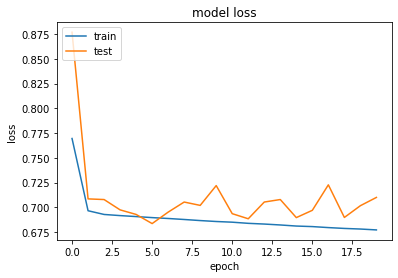

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Now to predict some and collec the stats

In [11]:
## Alzheimers Files
path, dirs, files = next(os.walk(toPredict_path_output + '/val/AD'))
file_count = len(files)
print(file_count)

## Normal Control Files
path, dirs, files = next(os.walk(toPredict_path_output + '/val/NC'))
file_count = len(files)
print(file_count)

NameError: ignored

In [31]:
## Setting up the filepaths for each file in NC
predict_normal_scan_paths = [
    os.path.join(os.getcwd(), toPredict_path_output + '/val/NC', x)
    for x in os.listdir(toPredict_path_output + '/val/NC')
]

## Setting up the filepaths for each file in class 2
predict_alzheimer_scan_paths = [
    os.path.join(os.getcwd(), toPredict_path_output + '/val/AD', x)
    for x in os.listdir(toPredict_path_output + '/val/AD')
]

In [32]:
## Normal Subject files into numpy arrays
predict_normal_volumes = np.array([processVolume(path) for path in predict_normal_scan_paths])
predict_normal_volume_labels = np.array([0 for _ in range(len(predict_normal_volumes))])

## Alzheimer's Subject files into numpy arrays
predict_alzheimer_volumes = np.array([processVolume(path) for path in predict_alzheimer_scan_paths])
predict_alzheimer_volume_labels = np.array([1 for _ in range(len(predict_alzheimer_volumes))])

print("MRI scans with normal neuro presentation: " + str(len(predict_normal_scan_paths)))
print("MRI scans with abnormal alzheimner's presentation: " + str(len(predict_alzheimer_scan_paths)))

MRI scans with normal neuro presentation: 12
MRI scans with abnormal alzheimner's presentation: 14


In [33]:
## Setting up the X and Y for predictions
X_predict = np.concatenate((predict_normal_volumes, predict_alzheimer_volumes), axis=0)
y_predict = np.concatenate((predict_normal_volume_labels, predict_alzheimer_volume_labels), axis=0)

In [34]:
## Applying the same RGB fix
X_predict_r, y_predict_r = train_preprocess(X_predict, y_predict)
print(X_predict_r.shape)
print(y_predict_r.shape)

(26, 224, 224, 3, 64)
(26,)


In [35]:
## Second the validation images
X_predict_f = threeDToTwoD(X_predict_r, 26)

## Third the training labels
y_predict_f = extendLabels(y_predict_r, 26)

In [38]:
## Doing the predictions and getting the metrics
prediction = reloaded_model.predict(X_predict_f)

loss, metrics = reloaded_model.evaluate(X_predict_f, y_predict_f)

52/52 [==============================] - 15s 276ms/step - loss: 0.6878 - binary_accuracy: 0.5751


In [39]:
## Displaying Predictions
print(prediction)
print(loss)
print(metrics)

[[0.48815608]
 [0.48505202]
 [0.4904107 ]
 ...
 [0.5153944 ]
 [0.5128732 ]
 [0.5138044 ]]
0.6878262758255005
0.575120210647583
